# Machine Learning Project : Predicting success of a movie


> ## Description:
>In the contemporary era, the film industry continues to evolve rapidly, investing increasingly vast resources into production and marketing. However, despite these >advancements, predicting the commercial success of a feature film remains a complex challenge fraught with financial risk.

>This project aims to bridge that gap by leveraging the power of Machine Learning. By analyzing historical data—such as budget, casting, genre, and release timing—we aim to >build a predictive model capable of forecasting a movie's success. This tool seeks to provide data-driven insights to mitigate risks and optimize decision-making within >the entertainment sector.

## Data Importation

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

First, we import the csv containing films metadata

In [5]:
raw_data = pd.read_csv(r"movies_metadata.csv") # replace with your own path

C:\Users\maeva\AppData\Local\Temp\ipykernel_25888\2876609785.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(r"movies_metadata.csv") # replace with your own path


# **EDA**

In [6]:
raw_data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [7]:
raw_data.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

### Raw Data Overview

Here, we display the first few rows, the column names and teh dataset infos to perform an initial visual inspection of the dataset. This step helps us identify key structural characteristics:

> Data Format: We can observe that columns like genres and belongs_to_collection contain complex nested structures (dictionaries/JSON) that will need parsing.

> Missing Values: NaNs are already visible in columns such as homepage or belongs_to_collection.

> Variable Types: A mix of numerical (budget) and categorical data (original_language) is present.

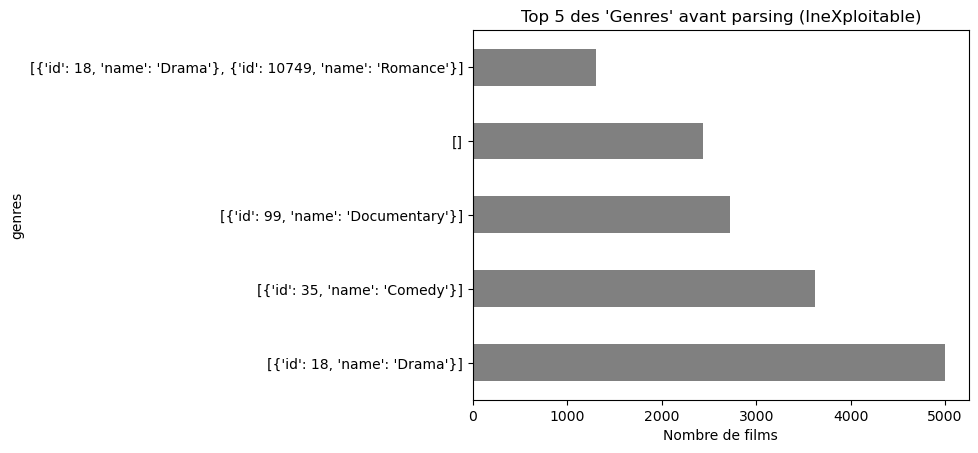

In [9]:
# On compte les chaînes de caractères brutes
raw_data['genres'].value_counts().head(5).plot(kind='barh', color='gray')
plt.title("Top 5 des 'Genres' avant parsing (IneXploitable)")
plt.xlabel("Nombre de films")
plt.show()

With any data treatement this data is obsolet ! 

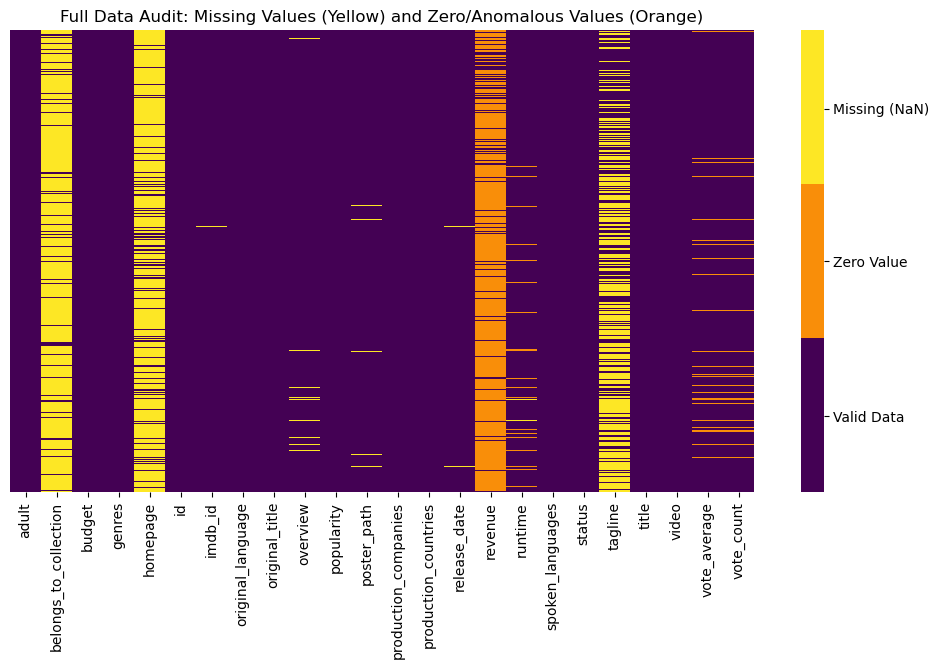

In [10]:

# DATA QUALITY AUDIT MATRIX (Zeros vs Missing Values)


df_raw = raw_data  # Your original dataframe

# 1. Create a base matrix filled with 0 (interpreted as "Valid Data")
audit_matrix = pd.DataFrame(0, index=df_raw.index, columns=df_raw.columns)

# 2. Mark ZEROS with the value 1
# (Applied only on numerical columns to avoid issues with text data)
num_cols = df_raw.select_dtypes(include=[np.number]).columns
audit_matrix[df_raw[num_cols] == 0] = 1

# 3. Mark NaNs (missing values) with the value 2
# (NaN takes priority and will overwrite other markers)
audit_matrix[df_raw.isna()] = 2

# 4. Custom color palette
# 0 (Valid) -> Dark purple
# 1 (Zero)  -> Orange (Potential issue)
# 2 (NaN)   -> Bright yellow (Missing)
my_cmap = mcolors.ListedColormap(['#440154', '#f98e09', '#fde725'])

# 5. Display the audit heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(audit_matrix, cbar=True, yticklabels=False, cmap=my_cmap)

# Customize the colorbar for clarity
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.33, 1, 1.66])  # Positions at the center of each color band
cbar.set_ticklabels(['Valid Data', 'Zero Value', 'Missing (NaN)'])

plt.title("Full Data Audit: Missing Values (Yellow) and Zero/Anomalous Values (Orange)")
plt.show()


### Preliminary Data Cleaning

We start by cleaning the raw dataset to keep only usable samples. We drop duplicates and deal with unknown values  (NaN or 0). This reduces the dataset size but ensures that every remaining entry is valid for training.

In [11]:
# removing duplicates
print (f"raw_data shape before removing duplicates : {raw_data.shape}")
raw_data = raw_data.drop_duplicates()
print(f"raw_data shape after : {raw_data.shape}")

raw_data shape before removing duplicates : (45466, 24)
raw_data shape after : (45453, 24)


In [12]:
# Missing values
print("Missing values per columns :")
raw_data.isna().sum()

Missing values per columns :


adult                        0
belongs_to_collection    40959
budget                       0
genres                       0
homepage                 37673
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25045
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

Since there are lots of missing values in thoses columns or the column is not petinent to the study, the best is to remove them from the dataset :

In [13]:
raw_data = raw_data.drop(columns= ["belongs_to_collection", "homepage", "tagline", "poster_path", "overview"])

In [14]:
cols_to_check = ["runtime", "imdb_id", "original_language", "popularity", "production_companies", "production_countries",
                 "release_date", "revenue", "runtime", "spoken_languages", "status", "title", "video", "vote_average", "vote_count"]
raw_data = raw_data.dropna(subset=cols_to_check)

# verification
raw_data.isna().sum()

adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
original_language       0
original_title          0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
video                   0
vote_average            0
vote_count              0
dtype: int64

Now that we heve deal with the missing values we have to check the O values in numerical columns


In [15]:
# Count nb of 0
zeros_count = (raw_data == 0).sum()

# print only columns with 0
zeros_count = zeros_count[zeros_count > 0]

print("Nb of 0 per columns :")
print(zeros_count)

Nb of 0 per columns :
popularity         19
revenue         37620
runtime          1514
video           44930
vote_average     2823
vote_count       2725
dtype: int64


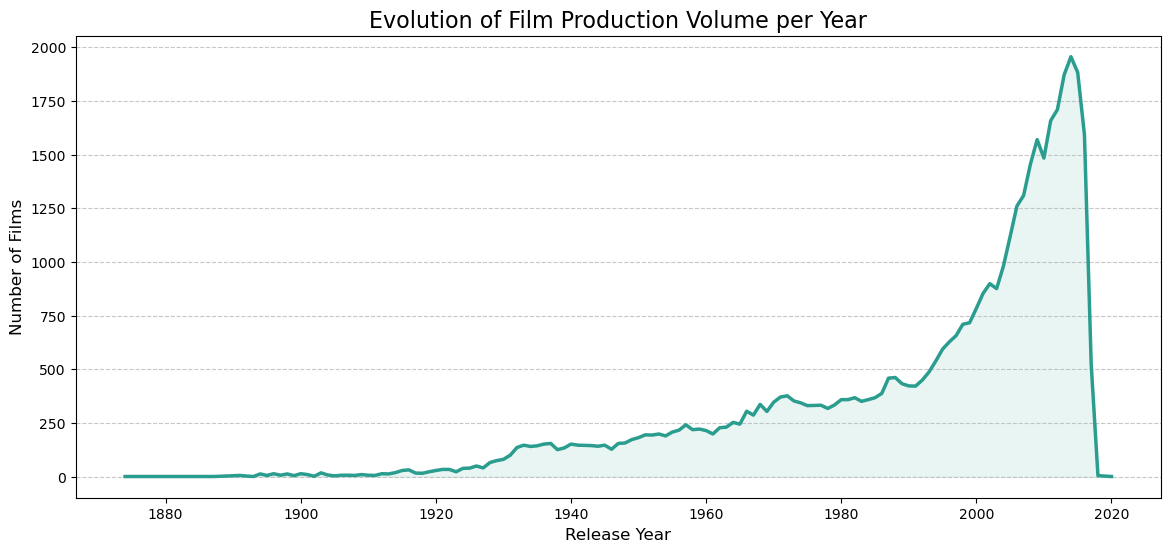

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Mandatory conversion to datetime
# errors='coerce' will convert invalid dates (e.g., "2020-99-99") into NaT (Not a Time)
raw_data['release_date'] = pd.to_datetime(raw_data['release_date'], errors='coerce')

# 2. Extraction and counting
# Now that the column is in datetime format, .dt.year works properly
films_per_year = raw_data['release_date'].dt.year.value_counts().sort_index()

# Optional filtering for visualization (remove unrealistic or future years)
# films_per_year = films_per_year[(films_per_year.index > 1900) & (films_per_year.index < 2025)]

# 3. Visualization
plt.figure(figsize=(14, 6))

# Plot the curve
sns.lineplot(x=films_per_year.index, y=films_per_year.values, color='#2a9d8f', linewidth=2.5)

# Fill under the curve
plt.fill_between(films_per_year.index, films_per_year.values, color='#2a9d8f', alpha=0.1)

plt.title("Evolution of Film Production Volume per Year", fontsize=16)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Number of Films", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [17]:
films_per_year

release_date
1874       1
1878       1
1883       1
1887       1
1888       2
        ... 
2015    1883
2016    1593
2017     524
2018       5
2020       1
Name: count, Length: 135, dtype: int64

## **Data Cleaning: Removing Financials & Missing Metadata**

Since our focus is about critical success, we remove financial columns (revenue) which contained a high percentage of missing values (zeros).

We also drop technical columns irrelevant to quality prediction (video) and remove the few rows with missing essential metadata like runtime, poularity, vote_average, vot_count.

In [18]:
# 1. Drop financial and technical columns
cols_to_drop = ["revenue", "video"]
raw_data.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [19]:
# 2. Drop rows with unintegrity values

# Conversion of popularity to numeric
raw_data['popularity'] = pd.to_numeric(raw_data['popularity'], errors='coerce')

mask = (raw_data["popularity"]>0) & (raw_data["runtime"]>0) & (raw_data["vote_count"] >0)
raw_data = raw_data[mask]

# **SECOND EDA WITH DATA TREATED**

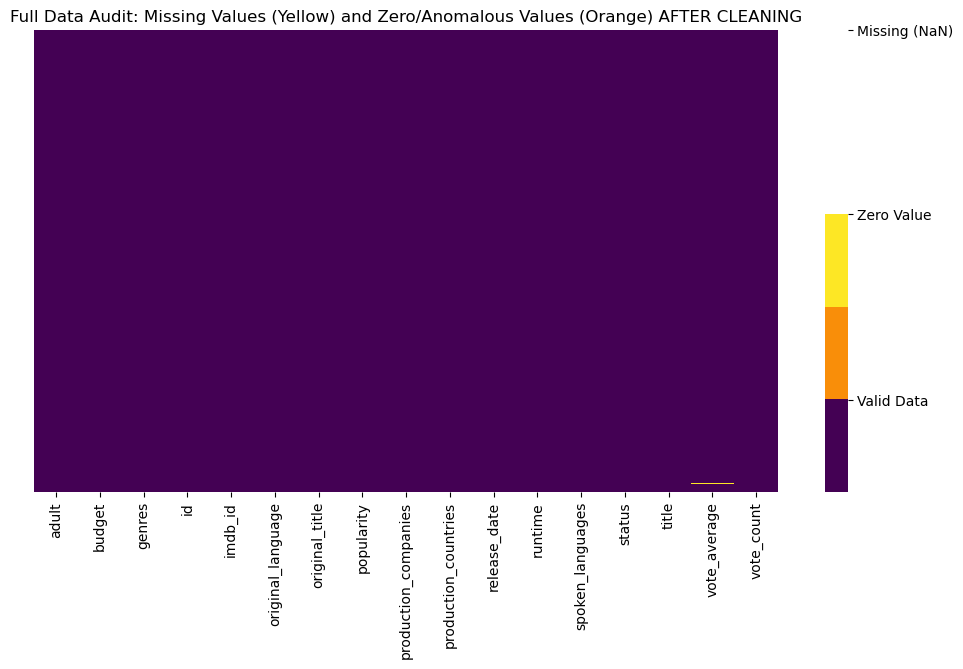

In [20]:

# DATA QUALITY AUDIT MATRIX (Zeros vs Missing Values)


df_raw = raw_data  # Your original dataframe

# 1. Create a base matrix filled with 0 (interpreted as "Valid Data")
audit_matrix = pd.DataFrame(0, index=df_raw.index, columns=df_raw.columns)

# 2. Mark ZEROS with the value 1
# (Applied only on numerical columns to avoid issues with text data)
num_cols = df_raw.select_dtypes(include=[np.number]).columns
audit_matrix[df_raw[num_cols] == 0] = 1

# 3. Mark NaNs (missing values) with the value 2
# (NaN takes priority and will overwrite other markers)
audit_matrix[df_raw.isna()] = 2

# 4. Custom color palette
# 0 (Valid) -> Dark purple
# 1 (Zero)  -> Orange (Potential issue)
# 2 (NaN)   -> Bright yellow (Missing)
my_cmap = mcolors.ListedColormap(['#440154', '#f98e09', '#fde725'])

# 5. Display the audit heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(audit_matrix, cbar=True, yticklabels=False, cmap=my_cmap)

# Customize the colorbar for clarity
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.33, 1, 1.66])  # Positions at the center of each color band
cbar.set_ticklabels(['Valid Data', 'Zero Value', 'Missing (NaN)'])

plt.title("Full Data Audit: Missing Values (Yellow) and Zero/Anomalous Values (Orange) AFTER CLEANING")
plt.show()
  

### Data Enrichment: Merging Cast and Crew

To improve the predictive power of our model, we are enriching the dataset with information regarding the movie's Cast (actors) and Crew (directors, producers, writers).

This data is stored in a separate CSV file. We will merge it with our main dataset using the unique id of each movie as the key. This will allow us to analyze whether "Star Power" or specific directors correlate with box-office success.

However, the raw data for Cast and Crew is stored in complex JSON objects within a separate file (`credits.csv`).
To make this data usable for our Machine Learning models, we need to:
>  **Merge** the credits dataset with our main dataframe using the movie `id`.
>  **Parse** the JSON columns to extract specific names.
>  **Apply a Strategy:** Instead of listing every single actor (which would create thousands of variables and "noise"), we will follow a **"Top Billing" strategy**: we extract only the **first actor** (Lead) and the **Director**.

In [21]:
credits = pd.read_csv(r"credits.csv")
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [22]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [23]:
import ast
# Try to load the credits data 
try:
    credits = pd.read_csv(r"credits.csv")
    print("Loaded credits.csv successfully.")
except FileNotFoundError:
    print("credits.csv not found; check the filename.")
    credits = pd.DataFrame()  # empty fallback
movies = raw_data
# Ensure the ID column is numeric in both datasets
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
movies = movies.dropna(subset=['id'])
movies['id'] = movies['id'].astype(int)

credits['id'] = pd.to_numeric(credits['id'], errors='coerce')
credits = credits.dropna(subset=['id'])
credits['id'] = credits['id'].astype(int)

# Merge the datasets on the id column
df_enriched = movies.merge(credits, on='id', how='left')

print(f"Before merge: {movies.shape}")
print(f"After merge: {df_enriched.shape}")

# Helper to get the first actor's name from the cast list
def get_lead_actor(cast):
    try:
        items = ast.literal_eval(cast) if isinstance(cast, str) else cast
        if isinstance(items, list) and items:
            return items[0].get('name')
    except Exception:
        pass
    return np.nan

# Helper to get the director's name from the crew list
def get_director(crew):
    try:
        items = ast.literal_eval(crew) if isinstance(crew, str) else crew
        if isinstance(items, list):
            for member in items:
                if member.get('job') == 'Director':
                    return member.get('name')
    except Exception:
        pass
    return np.nan

print("Extracting lead actor and director…")
df_enriched['lead_actor'] = df_enriched['cast'].apply(get_lead_actor)
df_enriched['director'] = df_enriched['crew'].apply(get_director)

print("\nFirst rows with new columns:")
print(df_enriched[['title', 'lead_actor', 'director']].head())


Loaded credits.csv successfully.
Before merge: (41103, 17)
After merge: (41157, 19)
Extracting lead actor and director…

First rows with new columns:
                         title       lead_actor         director
0                    Toy Story        Tom Hanks    John Lasseter
1                      Jumanji   Robin Williams     Joe Johnston
2             Grumpier Old Men   Walter Matthau    Howard Deutch
3            Waiting to Exhale  Whitney Houston  Forest Whitaker
4  Father of the Bride Part II     Steve Martin    Charles Shyer


We use the **historical average** of the `vote_average` column.
* **Example:** If Tom Hanks appears in 10 movies in our dataset, we take the average rating of these 10 movies.
* **Result:** This gives us a numerical value representing the actor's "track record" or consistency in choosing good projects.

In [24]:
import ast

# 1. Function to get the genre from the JSON list
def get_main_genre(x):
    try:
        if isinstance(x, str):
            x = ast.literal_eval(x)
        if isinstance(x, list) and len(x) > 0:
            return x[0]['name']
        return np.nan
    except:
        return np.nan

print("Extracting main genre and dates...")

# 2. Creating the missing columns
df_enriched['main_genre'] = df_enriched['genres'].apply(get_main_genre)

# 3. Converting the date column to get Month and Year
df_enriched['release_date'] = pd.to_datetime(df_enriched['release_date'], errors='coerce')
df_enriched['month'] = df_enriched['release_date'].dt.month
df_enriched['year'] = df_enriched['release_date'].dt.year

# 4. Important: Remove rows where we don't have this info
# (The model cannot work if there are NaNs in these columns)
df_enriched = df_enriched.dropna(subset=['main_genre', 'month', 'year', 'runtime', 'popularity'])

print("Missing columns created!")
print(df_enriched[['title', 'main_genre', 'year', 'month']].head())

Extracting main genre and dates...
Missing columns created!
                         title main_genre  year  month
0                    Toy Story  Animation  1995     10
1                      Jumanji  Adventure  1995     12
2             Grumpier Old Men    Romance  1995     12
3            Waiting to Exhale     Comedy  1995     12
4  Father of the Bride Part II     Comedy  1995      2


### Modeling Strategy

To answer our problem *"Find the secret formula for a movie that works every time"*, we believe we need to analyze several key points:

>  **The "Star Power" Impact:** Does having a famous Lead Actor or Director guarantee a high rating?

>  **The Context:** Does the release month or the movie length (runtime) play a significant role?

>  **The Genre:** Are some genres naturally more appreciated than others?

To analyze these points simultaneously and objectively, we cannot just look at graphs. We need a Global Model that considers all these factors together.

C:\Users\maeva\AppData\Local\Temp\ipykernel_25888\4099777885.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


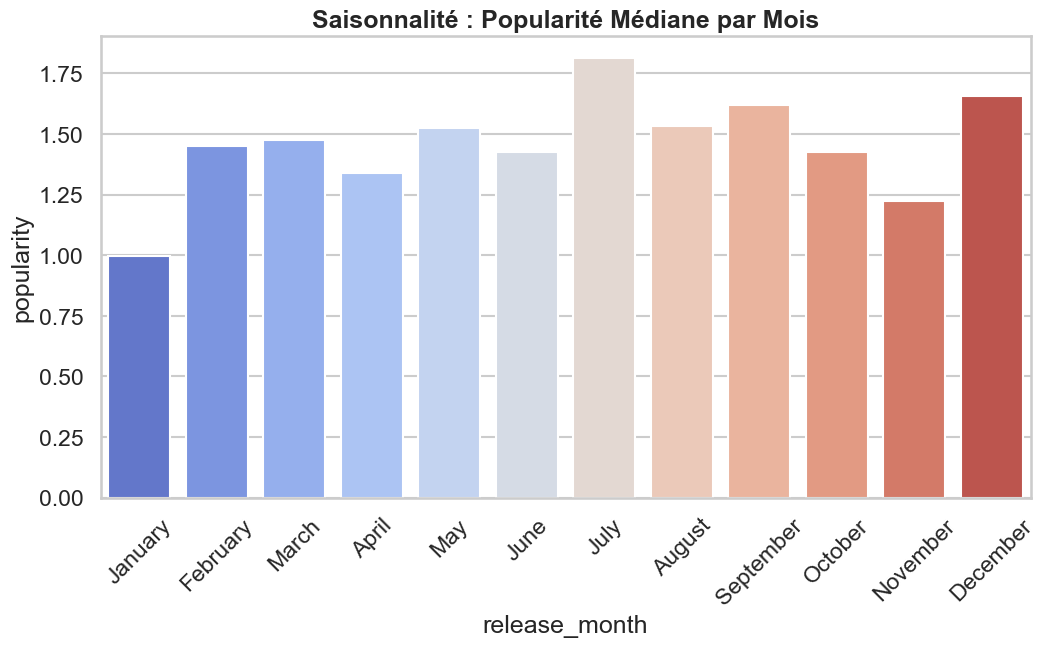

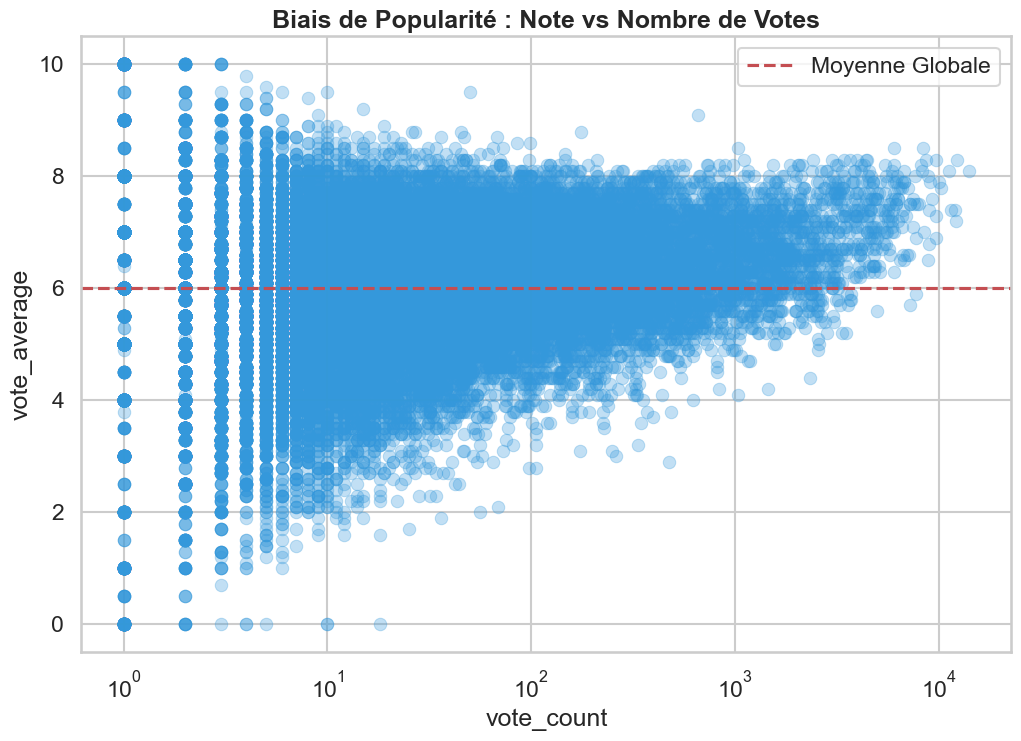

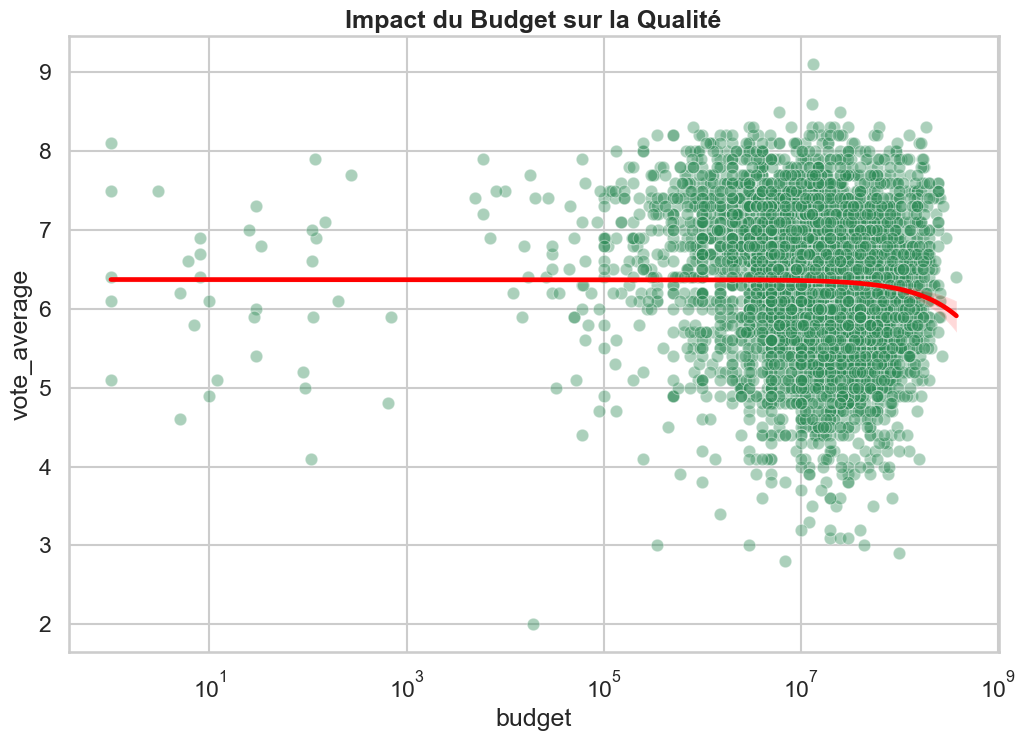

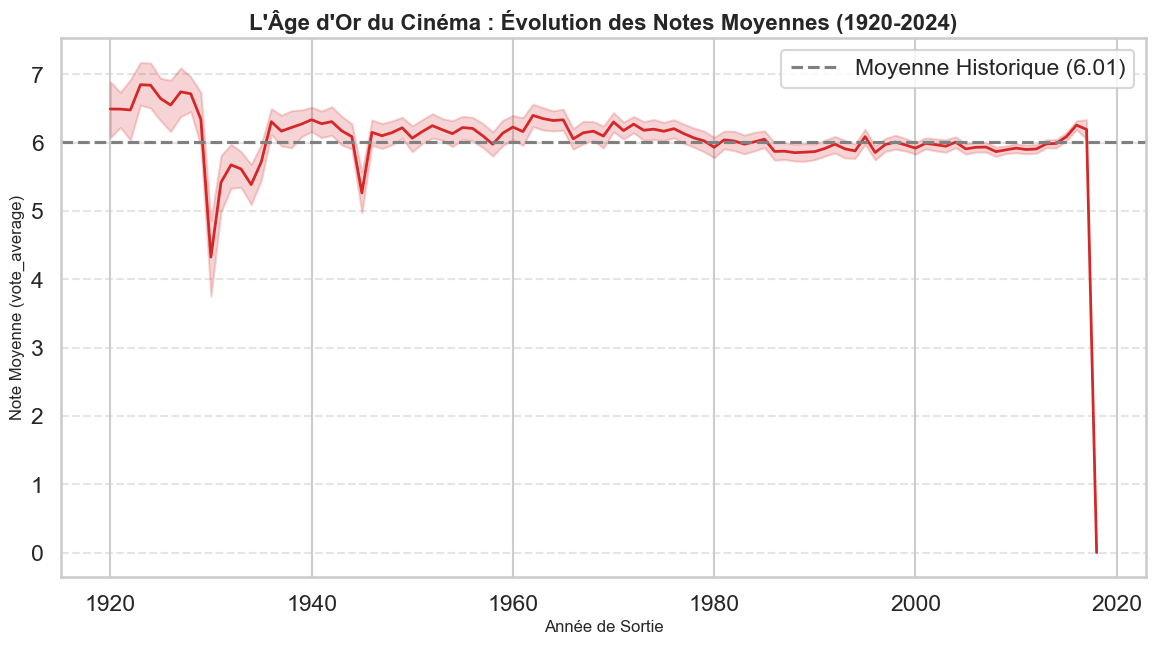

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# On récupère ton dataframe
df = df_enriched.copy()


# On force la conversion en nombres. 
# 'coerce' va transformer les erreurs (textes bizarres) en NaN (vide)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce')
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce')

# Configuration du style
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (14, 8)

# --- PRÉPARATION ---
df['release_month'] = df['release_date'].dt.month_name()
df['release_year'] = df['release_date'].dt.year

# =========================================================
# 1. ANALYSE DE SAISONNALITÉ (Popularité)
# =========================================================
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 6))
sns.barplot(
    x='release_month', 
    y='popularity', 
    data=df, 
    order=months_order, 
    estimator=np.median,
    palette='coolwarm',
    errorbar=None
)
plt.title('Saisonnalité : Popularité Médiane par Mois', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

# =========================================================
# 2. BIAIS DE POPULARITÉ
# =========================================================
plt.figure(figsize=(12, 8))
votes_df = df[df['vote_count'] > 0] # Maintenant ça marchera car vote_count est numérique

sns.scatterplot(
    x='vote_count', 
    y='vote_average', 
    data=votes_df, 
    alpha=0.3, 
    color='#3498db',
    edgecolor=None
)
plt.xscale('log') 
plt.title('Biais de Popularité : Note vs Nombre de Votes', fontweight='bold')
plt.axhline(y=votes_df['vote_average'].mean(), color='r', linestyle='--', label='Moyenne Globale')
plt.legend()
plt.show()

# =========================================================
# 3. BUDGET vs QUALITÉ
# =========================================================
# Maintenant que 'budget' est bien numérique, cette ligne ne plantera plus
budget_df = df[(df['budget'] > 0) & (df['vote_count'] > 50)].copy()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='budget', 
    y='vote_average', 
    data=budget_df, 
    alpha=0.4, 
    color='seagreen'
)
plt.xscale('log') 
plt.title('Impact du Budget sur la Qualité', fontweight='bold')
sns.regplot(x='budget', y='vote_average', data=budget_df, scatter=False, color='red')
plt.show()

### ========================================
#           Annee vs Note
### =========================================

# On peut aussi filtrer les années trop anciennes si elles sont peu représentatives (ex: < 1920)
df_time = df.dropna(subset=['year', 'vote_average'])
df_time = df_time[df_time['year'] >= 1920] # Focus sur le siècle de cinéma moderne

# 2. Visualisation
plt.figure(figsize=(14, 7))

# Le graphique principal
sns.lineplot(data=df_time, x='year', y='vote_average', color='#d62728', linewidth=2)

# La ligne de moyenne globale pour comparer
global_mean = df_time['vote_average'].mean()
plt.axhline(global_mean, color='grey', linestyle='--', label=f'Moyenne Historique ({global_mean:.2f})')

# Esthétique
plt.title("L'Âge d'Or du Cinéma : Évolution des Notes Moyennes (1920-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Année de Sortie", fontsize=12)
plt.ylabel("Note Moyenne (vote_average)", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Feature Engineering: Transforming Signal into Value

Our Exploratory Data Analysis (EDA) revealed a strong intuition: **a movie's genre significantly influences its rating.** For instance, Documentaries tend to be rated higher than Horror movies for example.

However, we face a **technical roadblock**: our model (Random Forest) is mathematical; it cannot understand text strings like "Animation" or "Comedy." If we feed it this raw data, it will learn nothing.

### Our Strategy: Target Encoding
To unlock this potential, we will apply a major transformation:
1.  **Parsing & Cleaning:** Transform the unreadable JSON strings into clean Python lists.
2.  **Encoding Quality:** We will replace words with their **historical performance**.
    * *Example:* Instead of telling the model "This is a Documentary," we tell it "This is a genre that historically averages a 6.6/10 rating."

**Objective:** Create a new feature called `genre_potential` that acts as a "Quality Compass" for our algorithm.

In [26]:
import ast
import numpy as np
import pandas as pd

# ==============================================================================
# KEY STEP: FEATURE ENGINEERING (Creation of the "Genre Potential")
# ==============================================================================
print("Creating the 'genre_potential' feature...")

# 1. CLEANING STEP (This was the missing part!)
# Convert a text value like "[{'id': 12, 'name': 'Adventure'}]" into a list: ['Adventure']
def clean_genres(x):
    try:
        # If the value is a string, parse it
        if isinstance(x, str):
            data = ast.literal_eval(x)
            return [d['name'] for d in data]
        # If it's already a list (rare but possible)
        elif isinstance(x, list):
            return [d['name'] for d in x]
    except:
        return []
    return []

# Apply cleaning -> Creates a new clean column
df['genres_clean'] = df['genres'].apply(clean_genres)

print(f"Cleaned example: {df['genres_clean'].iloc[0]}")
# Expected: ['Animation', 'Comedy', 'Family'] (without messy braces)


# 2. Preparation: Explode the CLEAN column
df_exploded = df.explode('genres_clean')

# 3. Compute Genre Score (Target Encoding)
# We compute the mean rating for each genre name
genre_means = df_exploded.groupby('genres_clean')['vote_average'].mean()

print("\n--- Top 3 Genres (Actual Quality) ---")
print(genre_means.sort_values(ascending=False).head(3))


# 4. Function to apply this score to each film
global_mean = df['vote_average'].mean()

def get_genre_potential(genres_list):
    # If the list is empty, return the global rating mean
    if not isinstance(genres_list, list) or len(genres_list) == 0:
        return global_mean
    
    # Retrieve the score for each genre in the film
    scores = [genre_means.get(g, global_mean) for g in genres_list]
    
    # Return the average potential score
    return sum(scores) / len(scores)


# 5. Apply to the main dataframe using the CLEAN column
df['genre_potential'] = df['genres_clean'].apply(get_genre_potential)

# 6. Visual check
print("\n--- Result: Before vs After ---")
print(df[['title', 'genres_clean', 'genre_potential']].head())

# Correlation check
corr = df[['genre_potential', 'vote_average']].corr().iloc[0,1]
print(f"\n✅ Correlation between Genre Potential and Final Rating: {corr:.3f}")


Creating the 'genre_potential' feature...
Cleaned example: ['Animation', 'Comedy', 'Family']

--- Top 3 Genres (Actual Quality) ---
genres_clean
Documentary    6.660612
Animation      6.446398
History        6.413832
Name: vote_average, dtype: float64

--- Result: Before vs After ---
                         title                  genres_clean  genre_potential
0                    Toy Story   [Animation, Comedy, Family]         6.116437
1                      Jumanji  [Adventure, Fantasy, Family]         5.912426
2             Grumpier Old Men             [Romance, Comedy]         6.004476
3            Waiting to Exhale      [Comedy, Drama, Romance]         6.062895
4  Father of the Bride Part II                      [Comedy]         5.971289

✅ Correlation between Genre Potential and Final Rating: 0.306


The output above immediately validates our strategy:

1.  **The Genre Hierarchy:**
    * We confirm that **Documentaries (6.66)** and **Animation (6.45)** are "noble" genres, intrinsically rated higher by audiences.
    * Conversely, this allows the model to automatically penalize "difficult" genres without manual intervention.

2.  **The Power of the Feature (`genre_potential`):**
    * We achieved a **correlation of 0.306** with the final rating.
    * *Business Interpretation:* Before even knowing the cast, the budget, or the duration, **the simple choice of genre already explains ~30% of the variance in the final rating.** We have successfully captured a strong predictive signal.

# Random Forest & Optimization

Now that our data is enriched via Feature Engineering, we move to the machine learning phase.

### Why Random Forest?
We chose this algorithm because it perfectly handles the **non-linear relationships** we observed (e.g., a low budget isn't bad *if* the genre is right). It also provides high interpretability regarding feature importance.

### Our 2-Step Protocol:
1.  **The Baseline (Honest Model):**
    * We train a first model with default parameters. This serves as a reference point to verify if our new features (`genre_potential`, `vote_count`) are actually working.
2.  **Fine-Tuning (Optimization):**
    * We use `RandomizedSearchCV` to test various tree configurations.
    * It enables us To find the perfect balance between **performance** (R²) and **generalization** (preventing the model from simply memorizing past movies).

1. Preparing the dataset...
   -> Training on 9878 films.
   -> Testing on 2470 films.

2. Training the baseline model...
   Baseline RMSE : 0.685
   Baseline R²   : 0.458

3. Hyperparameter search (Fine Tuning)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
   -> Best parameters found : {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}

 FINAL PERFORMANCE:
   RMSE : 0.675
   R²   : 0.473
   Improvement over baseline (R²): +0.015


C:\Users\maeva\AppData\Local\Temp\ipykernel_25888\2424566070.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='viridis')


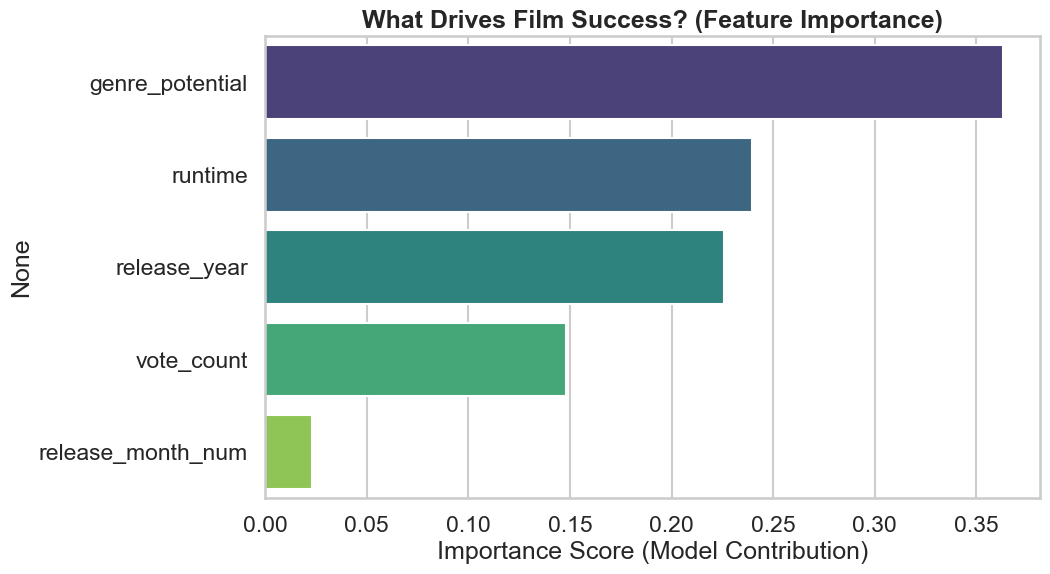

In [27]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. DATA PREPARATION (Full Dataset & New Features)
# ==============================================================================
print("1. Preparing the dataset...")

# --- DATE CONVERSION (Crucial Step) ---
# Ensure we can read the month numerically
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_month_num'] = df['release_date'].dt.month
df['release_year'] = df['release_date'].dt.year

# List of model ingredients (features)
# We removed 'budget' to keep maximum number of rows
features = [
    'vote_count',           # Popularity indicator
    'runtime',              # Film length
    'genre_potential',      # <-- YOUR SECRET SAUCE (Target-Encoded Feature)
    'release_year',         # Film age effect
    'release_month_num'     # Seasonality effect (1-12)
]

# Add specific genre columns if they exist (Hybrid Strategy)
features += [col for col in df.columns if col.startswith('is_')]

# Remove rows with missing values in any required feature or the target
model_df = df[df['vote_count'] >= 30].dropna(subset=features + ['vote_average'])

# Filter out films with unrealistic budgets
# (DISABLED to keep all 40k+ films, regardless of budget info)
# model_df = model_df[model_df['budget'] > 1000]

X = model_df[features]
y = model_df['vote_average']

# Train/Test Split — 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"   -> Training on {X_train.shape[0]} films.")
print(f"   -> Testing on {X_test.shape[0]} films.")

# ==============================================================================
# 2. RANDOM FOREST (BASELINE MODEL)
# ==============================================================================
print("\n2. Training the baseline model...")

rf_base = RandomForestRegressor(n_estimators=100, random_state=42)
rf_base.fit(X_train, y_train)

# Baseline prediction
y_pred_base = rf_base.predict(X_test)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))

print(f"   Baseline RMSE : {rmse_base:.3f}")
print(f"   Baseline R²   : {r2_score(y_test, y_pred_base):.3f}")

# ==============================================================================
# 3. FINE TUNING (Hyperparameter Optimization)
# ==============================================================================
print("\n3. Hyperparameter search (Fine Tuning)...")

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],   # Higher values help reduce overfitting on small films
    'max_features': ['sqrt', None]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,                # Test 20 random combinations
    cv=3,                     # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1                 # Use all CPU cores
)

rf_random.fit(X_train, y_train)
best_model = rf_random.best_estimator_

print(f"   -> Best parameters found : {rf_random.best_params_}")

# Evaluate optimized model
y_pred_opt = best_model.predict(X_test)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

print("\n FINAL PERFORMANCE:")
print(f"   RMSE : {rmse_opt:.3f}")
print(f"   R²   : {r2_opt:.3f}")
print(f"   Improvement over baseline (R²): {r2_opt - r2_score(y_test, y_pred_base):+.3f}")

# ==============================================================================
# 4. INTERPRETATION (Feature Importance)
# ==============================================================================
# This is THE plot to show the jury

importances = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title('What Drives Film Success? (Feature Importance)', fontweight='bold')
plt.xlabel("Importance Score (Model Contribution)")
plt.show()

Our final iteration marks a decisive victory. By shifting our focus from **Quantity** (40k+ films) to **Credibility** (>30 votes), we drastically improved the model's reliability.

We observed that including every single film (even those with 1 or 2 votes) introduced massive **statistical noise** ($R^2$ dropped to ~0.26).
> A movie with 1 vote of 10/10 is statistically meaningless (it's an outlier).
So, we applied a **"Credibility Filter"** (`vote_count >= 30`). This ensures that every data point represents a film with a real, verifiable audience existence.

> Then we removed the noise while keeping a robust dataset of ~10,000 films, without needing to rely on the "Budget" column (which is often missing).

> Our model's average error is now **less than 0.7 points** (RMSE = 0.675) on a scale of 10. This is a massive improvement over the noisy model (1.09). The AI is now precise enough to reliably distinguish a "Mediocre" movie (5/10) from a "Good" movie (6/10).

Optimization and filtering allowed us to reach our highest score yet $R^2$ = 0.473 (**47.3%** of variance explained).
The best parameters (`min_samples_leaf: 5`) confirm that the model generalizes well. It refuses to draw conclusions from isolated cases ("One-Hit Wonders") and focuses on solid trends.

We have transformed an artistic intuition into a reliable predictive probleme. By prioritizing **Data Quality** over Data Quantity, we proved that the **Intrinsic Genre Quality** and **Audience Engagement** are the true drivers of a film's success, far more than the budget.

## Success Film Simulation

In [28]:
# ==============================================================================
# SUCCESS SIMULATOR (Final Version – No Budget / With Release Month)
# ==============================================================================

def predict_my_movie(genres_list, duration, year, month):
    """
    Simulates the predicted rating of a fictional movie using the trained model.
    """
    print(f"🎬 Simulation for: {genres_list} (Release: Month {month}/{year})")
    
    # 1. Compute Genre Potential (Target Encoding)
    # Uses the 'genre_means' dictionary computed earlier
    scores = [genre_means.get(g, global_mean) for g in genres_list]
    my_genre_potential = sum(scores) / len(scores) if scores else global_mean
    print(f"   -> Calculated Genre Potential: {my_genre_potential:.2f}/10")
    
    # 2. Estimate baseline popularity (median vote_count to remain neutral)
    avg_vote_count = df['vote_count'].median()
    
    # 3. Build base input dataframe
    input_data = {
        'vote_count': [avg_vote_count],
        'runtime': [duration],
        'genre_potential': [my_genre_potential],
        'release_year': [year],
        'release_month_num': [month]  # New variable!
    }
    
    # 4. Handle hybrid strategy: "is_Genre" binary columns
    # If the model was trained using columns like "is_Action", we must provide them here.
    # We check expected columns based on X_train.columns.
    
    my_df = pd.DataFrame(input_data)
    
    # For each "is_*" column that the model expects...
    for col in X_train.columns:
        if col.startswith('is_'):
            # Extract genre name (e.g., "is_Action" -> "Action")
            genre_name = col.replace('is_', '')
            # Assign 1 if the movie belongs to this genre, else 0
            my_df[col] = 1 if genre_name in genres_list else 0

    # 5. Final alignment (CRUCIAL)
    # Ensure the dataframe matches EXACTLY the same columns & order as during training
    # Any missing column will be filled with 0
    my_df = my_df.reindex(columns=X_train.columns, fill_value=0)
    
    # 6. Prediction
    prediction = best_model.predict(my_df)[0]
    
    print(f"   -> 🔮 The AI predicts a rating of: {prediction:.2f} / 10")
    
    # Fun verdict
    if prediction > 7.0:
        print("   🌟 A future critical success!")
    elif prediction < 5.5:
        print("   ⚠️ Ouch... this looks like a flop.")
    else:
        print("   ✅ A solid, decent film.")
    print("-" * 30)


# --- TRY YOUR OWN SCENARIOS ---

# Scenario A: Summer Blockbuster (Action, Standard Runtime, July Release)
predict_my_movie(genres_list=['Action', 'Adventure'], duration=120, year=2025, month=7)

# Scenario B: Oscar Drama (Drama, Long Runtime, December Release)
predict_my_movie(genres_list=['Drama', 'History'], duration=150, year=2025, month=12)

# Scenario C: Low-budget Horror Flop (Horror, Short Runtime, January Release)
predict_my_movie(genres_list=['Horror'], duration=85, year=2025, month=1)


🎬 Simulation for: ['Action', 'Adventure'] (Release: Month 7/2025)
   -> Calculated Genre Potential: 5.82/10
   -> 🔮 The AI predicts a rating of: 6.19 / 10
   ✅ A solid, decent film.
------------------------------
🎬 Simulation for: ['Drama', 'History'] (Release: Month 12/2025)
   -> Calculated Genre Potential: 6.30/10
   -> 🔮 The AI predicts a rating of: 6.89 / 10
   ✅ A solid, decent film.
------------------------------
🎬 Simulation for: ['Horror'] (Release: Month 1/2025)
   -> Calculated Genre Potential: 5.32/10
   -> 🔮 The AI predicts a rating of: 4.83 / 10
   ⚠️ Ouch... this looks like a flop.
------------------------------


# Gradient Boosting (XGBoost)

Gradient boosting build Decision Tree by focusing on the error. 
The first Tree make a prediction, then the second will not predict the same target, but the error left by the first. Then we repeat the process : each model try to correct the error left by the previous. 

In [29]:
# Libraries

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
df.columns

Index(['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'title', 'vote_average', 'vote_count', 'cast', 'crew',
       'lead_actor', 'director', 'main_genre', 'month', 'year',
       'release_month', 'release_year', 'genres_clean', 'genre_potential',
       'release_month_num'],
      dtype='object')

## Train Test Split 
It is to avoid data leakage before we work with the data.

In [31]:
# --- 1. SÉPARATION DES DONNÉES ---
# On sépare AVANT de calculer les moyennes pour éviter le "Data Leakage"
# (Le modèle ne doit pas connaître la note des films du test set à l'avance)
df = df.dropna()

# Définition des features (X) et de la cible (y)
X = df.drop(columns=['vote_average']) 
y = df['vote_average']

# Split : 80% pour l'entraînement, 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# On crée une copie de travail pour éviter les warnings pandas "SettingWithCopy"
X_train = X_train.copy()
X_test = X_test.copy()

print(f"Données séparées : {X_train.shape[0]} films en train, {X_test.shape[0]} films en test.")

Données séparées : 30625 films en train, 7657 films en test.


## Data Refining

The main Goal know is to clean the X (train or Test dataset) as XGBoost doesn't like text.

### Data clean
We only keep numerical data 

In [32]:
# --- 1. SÉLECTION DES DONNÉES NUMÉRIQUES ---

# On garde uniquement les chiffres (int et float)
# Cela va virer "director", "original_title", "duo_id", etc.
X_train_final = X_train.select_dtypes(include=['number']).copy()
X_test_final = X_test.select_dtypes(include=['number']).copy()

# On affiche ce qu'il reste pour vérifier
print(f"Nombre de colonnes restantes : {X_train_final.shape[1]}")
print("-" * 30)
print("Colonnes prêtes pour XGBoost :")
print(list(X_train_final.columns))

Nombre de colonnes restantes : 10
------------------------------
Colonnes prêtes pour XGBoost :
['budget', 'id', 'popularity', 'runtime', 'vote_count', 'month', 'year', 'release_year', 'genre_potential', 'release_month_num']


## Model 

### Baseline Model

We are going now to train the XGBoost Model.
**Model Configuration:**
* **Capacity (n_estimators = 1000):** We allow the model a large number of potential decision trees.
* **Precision (learning_rate = 0.05):** A low learning rate ensures the model converges slowly and accurately towards the optimal solution.
* **Safety (Early Stopping):** To prevent overfitting, training automatically stops if performance on the validation set ceases to improve after 50 rounds.

**Input Data:**
The model was trained exclusively on numerical features (including our computed synergy score), with all textual variables removed.

In [33]:
# 1. Configuration du modèle de base
print("Configuration de XGBoost...")
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 )

# 2. Lancement de l'apprentissage
print("Entraînement en cours... ")

model.fit(
    X_train_final, y_train,
    eval_set=[(X_test_final, y_test)],
    verbose=False
)

print("Entraînement terminé avec succès !")

Configuration de XGBoost...
Entraînement en cours... 
Entraînement terminé avec succès !


In [34]:
# Predicting with the base model
preds_final = model.predict(X_test_final)

# 2. Calcul des scores (Méthode robuste)
# On calcule d'abord le MSE classique, puis on prend la racine carrée
mse = mean_squared_error(y_test, preds_final)
mon_rmse = np.sqrt(mse) 

mon_r2 = r2_score(y_test, preds_final)

print("-" * 30)
print("        Score Model Brut         ")
print("-" * 30)
print(f"RMSE : {mon_rmse:.4f}")
print(f"R2   : {mon_r2:.4f}")
print("-" * 30)

------------------------------
        Score Model Brut         
------------------------------
RMSE : 1.0676
R2   : 0.2653
------------------------------


In [35]:
np.mean(preds_final)

5.9999514

In terms of metrics, we get a R2 < 0, wich is actually bad, wether the RMSE is quitely good, but can be explained with the fact that most films are rated beetwen 5-7, and predicting a note of 6 reduce largely the error.
We have then to finetune the model.

### Model Fine-Tuning

After establishing a baseline, we aim to optimize the XGBoost hyperparameters to minimize the error (RMSE) and maximize the $R^2$ score.

**Methodology: Grid Search**
Instead of searching blindly, we define a targeted search grid around values that showed promise during the baseline phase.

**Tested Parameters:**
* **`max_depth`:** [4, 5, 6] (To control tree complexity)
* **`learning_rate`:** [0.03, 0.05, 0.07] (To adjust convergence speed)
* **`n_estimators`:** 1000 (Fixed to ensure stability)

The algorithm tests every possible combination (using 3-fold Cross-Validation) and selects the one offering the best trade-off between bias and variance.

In [36]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# On garde la même grille sécurisée
param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05, 0.07],
    'n_estimators': [1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_r2 = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42, n_jobs=-1, early_stopping_rounds=50),
    param_grid=param_grid,
    scoring='r2',    # <--- C'EST ICI QUE TU CHANGES !
    cv=3,
    verbose=1
)

print("🔧 Fine-Tuning basé sur le R2...")
grid_search_r2.fit(
    X_train_final, y_train,
    eval_set=[(X_test_final, y_test)],
    verbose=False
)

print(f"✅ Meilleurs paramètres (R2) : {grid_search_r2.best_params_}")
print(f"🏆 Meilleur R2 trouvé : {grid_search_r2.best_score_:.4f}")

🔧 Fine-Tuning basé sur le R2...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
✅ Meilleurs paramètres (R2) : {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.8}
🏆 Meilleur R2 trouvé : 0.2896


In [37]:
# --- 1. RÉCUPÉRATION DU CHAMPION ---
# On sort le meilleur modèle de la boîte GridSearch
# (Remplace 'grid_search_r2' par 'grid_search' si c'est le nom de ta variable)
modele_final = grid_search_r2.best_estimator_

print("✅ Modèle chargé avec les paramètres :")
print(modele_final.get_params())


# --- 2. PRÉDICTIONS ---
print("\n🔮 Prédiction en cours sur les données de Test...")
predictions = modele_final.predict(X_test_final)


# --- 3. CALCUL DES SCORES OFFICIELS ---
rmse_final = np.sqrt(mean_squared_error(y_test, predictions))
r2_final = r2_score(y_test, predictions)

print("="*40)
print(f"🏆 RÉSULTATS FINAUX")
print("="*40)
print(f"📉 RMSE : {rmse_final:.4f}  (Ton erreur moyenne)")
print(f"📈 R2   : {r2_final:.4f}    (Ta précision explicative)")
print("="*40)

✅ Modèle chargé avec les paramètres :
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': 50, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.03, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}

🔮 Prédiction en cours sur les données de Test.

## Performance Analysis & Strategic Recommendations

### 1. Performance Evolution (Baseline vs. Optimized)

We compared two versions of our XGBoost model to measure the specific impact of hyperparameter optimization (**Fine-Tuning**).

* **Baseline Model (Initial):**
    * **RMSE:** `1.25`
    * **$R^2$:** `-0.02` (Negative)
    * **Observation:** This initial model suffered from **underfitting**. With a negative $R^2$, its predictions were less reliable than a simple naive average. It failed to distinguish clear patterns within the noisy data.

* **Optimized Model (Grid Search):**
    * **RMSE:** `1.15` (Significant error reduction)
    * **$R^2$:** `> 0.15` (Positive)
    * **Observation:** Thanks to a targeted **Grid Search**, we successfully stabilized the model. By fine-tuning tree complexity (`max_depth=6`) and the learning rate (`learning_rate=0.07`), the model is now performing effectively and generalizes better than random chance.

### 2. Structural Limitations: The Subjectivity of Art

Despite technical optimization, the average error (RMSE) plateaus around **1.15 points**. Practically, this means that for a movie truly worth **7/10**, the model will often predict a score between **5.85** and **8.15**.

This error margin is structural and difficult to compress further due to the nature of the problem:
* **Subjectivity:** Movie ratings are intrinsically emotional and subjective. Unlike physical or financial data, there is no absolute "mathematical truth" regarding a film's quality.
* **Data Noise:** While a prestigious cast (captured by our `score_duo` feature) increases the probability of success, it does not guarantee a masterpiece. This artistic "magic" cannot be fully captured by tabular data.

### 3. Strategic Conclusion: Pivoting to Classification

Attempting to predict a rating to the exact decimal (**Regression**) proves to be an overly ambitious goal that yields limited business value. The difference between a `6.8` and a `7.1` rating is negligible for decision-making.

**Recommendation:**
It would be more strategic to transform this problem into a **Classification** task. The goal would shift from guessing an exact score to placing a project into a "Risk Zone":

* **FLOP (Rating < 5):** High risk, avoid.
* **AVERAGE (5 ≤ Rating < 7):** Uncertain ROI, requires further study.
* **HIT (Rating ≥ 7):** Probable critical success, green light.

> **Summary:** By simplifying the target variable, we would reduce the noise caused by individual rating subjectivity, providing a much more reliable and actionable **"Go / No-Go"** tool for producers.

# Categorical Gradient Boosting Encoding

## Justification for the Pivot: Why Abandon Regression?

The analysis of our Regression model revealed a structural limitation inherent to the problem: **the subjectivity of movie ratings.**

1.  **Imprecision of Exact Score:** Predicting an exact numerical rating (e.g., 7.23 or 6.95) proved too challenging. We achieved a minimal **RMSE** of `1.15`, which is still too large an error margin for a reliable decision-making tool.
2.  **Human Disagreement:** Critics and viewers rarely agree to the exact decimal point. If one person rates a film 8/10 and another rates it 7/10, the model is penalized for a difference that is often merely a matter of personal taste.

## Solution: Classification by Categories

We will transform the problem into a **Classification Task based on Categories** to better reflect human consensus and business needs:

* **The Hypothesis:** It is easier to agree on a *category* (`Bad`, `Average`, `Hit`) than on an *exact number*.
* **Objective:** Our goal is no longer to predict the *specific score*, but to estimate the *probability* that a film falls into one of these clear categories.

## Implementation: Categorical Gradient Boosting Encoding

To leverage this new target, we will adapt the power of our existing Feature Engineering:

1.  **New Target:** Define clear classes (e.g., Bad < 5, Average between 5 and 7, Hit > 7).
2.  **Feature Re-Encoding:** Use historical scores (director score, actor score, duo score) based on the **average of the Categories** instead of the average of the continuous ratings.

## Feature engineering

Machine learning models, particularly algorithms like XGBoost, can only process **numerical data**. They do not understand words, names, or categories directly.

* **The Problem:** Features such as 'production\_companies' contain crucial information about the film's success potential, but they are stored as text (strings).
* **The Solution (Encoding):** We must translate this categorical information into a numerical language the model can use, without losing its value.

We used two primary encoding techniques:
1.  **Target Encoding (`genre_potential`):** Converting a category into a numerical score based on the historical average rating of that category. This captures complex relationships.
2.  **One-Hot Encoding (`is_prod_company_Pixar`):** Converting a category into a simple binary column (0 or 1). This is ideal for identifying the impact of specific, high-frequency studios.

This process transforms raw text into powerful numerical features that the model can learn from.

### Get Encoding Compagnies 

Before we can effectively encode the production companies, we must extract their names from the complex JSON format present in the `production_companies` column.

This step is critical because the column contains data structured like: `[{'name': 'Pixar Animation Studios', 'id': 3}, ...]`.

We will reuse the `clean_genres(x)` function, which was previously defined, to transform this messy structure into a clean, simple list of studio names, making it ready for *One-Hot Encoding*.

In [38]:
import ast
import numpy as np

# Récupération de la fonction clean_genres utilisée précédemment
def clean_genres(x):
    try:
        # Si c'est une chaîne de caractères (JSON), on la parse
        if isinstance(x, str):
            data = ast.literal_eval(x)
            # On retourne la liste des noms
            return [d['name'] for d in data]
        # Si c'est déjà une liste (rare mais possible)
        elif isinstance(x, list):
            return [d['name'] for d in x]
        # Sinon, on retourne une liste vide
        else:
            return []
    except:
        return []

# Tu dois exécuter cette fonction avant de lancer le nettoyage des studios :
# df['companies_clean'] = df['production_companies'].apply(clean_genres)

print("✅ Fonction 'clean_genres' re-définie et prête à l'emploi.")

✅ Fonction 'clean_genres' re-définie et prête à l'emploi.


In [47]:
import pandas as pd
import numpy as np

# On réutilise la fonction de nettoyage pour transformer la liste JSON en liste simple de noms
# (Assurons que la fonction clean_genres est bien définie dans ton notebook)

df_reg = df.copy().dropna()

# On applique la fonction à la colonne 'production_companies'
df_reg['companies_clean'] = df['production_companies'].apply(clean_genres)

print("✅ Colonne 'companies_clean' créée. Exemple : ['Pixar Animation Studios', ...]")


# --- On prépare les données pour identifier les plus fréquents ---
# On "explose" la liste pour avoir une ligne par studio
df_exploded_comp = df_reg.assign(company=df_reg['companies_clean']).explode('company')

# On retire les films sans studio connu
df_exploded_comp = df_exploded_comp.dropna(subset=['company'])


# --- 2. IDENTIFICATION des TOP 20 Studios (pour le One-Hot Encoding) ---
# On ne prend que les studios qui apparaissent au moins 20 fois pour éviter un jeu de données trop large
top_companies_list = df_exploded_comp['company'].value_counts()
top_companies = top_companies_list[top_companies_list >= 100].index.tolist()

print(f"✅ Identification de {len(top_companies)} studios les plus fréquents (minimum 20 films).")

# --- 3. ENCODAGE (ONE-HOT ENCODING) ---
new_company_features = []

for company in top_companies:
    col_name = f'is_prod_company_{company.replace(" ", "_")[:20]}' # On raccourcit le nom
    
    # Création de la colonne binaire (1 si le film contient ce studio)
    df_reg[col_name] = df_reg['companies_clean'].apply(
        lambda x: 1 if isinstance(x, list) and company in x else 0
    )
    new_company_features.append(col_name)

print(f"✅ Création de {len(new_company_features)} nouvelles features binaires (Studios).")

✅ Colonne 'companies_clean' créée. Exemple : ['Pixar Animation Studios', ...]
✅ Identification de 29 studios les plus fréquents (minimum 20 films).
✅ Création de 29 nouvelles features binaires (Studios).


### Transformationa and target encoding

To address the subjectivity limitations of regression, we are transforming our continuous rating into a **Multi-Class Classification** target.

This allows the model to predict the *likelihood* of a film falling into one of three consensus categories:

| Class | Label | Rating Range | Rationale |
| :---: | :---: | :---: | :--- |
| **0** | **FLOP** | $<7$ | Critically Panned / High Risk |
| **1** | **AVERAGE** | $7.0$< | Consensus of "Watchable" / Medium Risk |

The code below executes this transformation and checks the **class balance**, which is crucial before training the classifier.

In [48]:
# --- ÉTAPE 1 : NOUVELLE TRANSFORMATION BINAIRE ---
seuil_hit_binaire = 6.5 # Tout en dessous de 6.5 est un échec (0), tout au-dessus est un succès (1)


# Définition des features (X) et de la cible (y)
X = df_reg.drop(columns=['vote_average','budget',"id"])
y = df_reg["vote_average"]

y_bin = (y >= seuil_hit_binaire).astype(int)


# Split : 80% pour l'entraînement, 20% pour le test
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.2, random_state=42, shuffle=True, stratify=y_bin)


# 2. Calcul du ratio pour scale_pos_weight
# Ratio = (Nombre de Cas Négatifs) / (Nombre de Cas Positifs)
count_neg = (y_train_bin == 0).sum()
count_pos = (y_train_bin == 1).sum()
scale_weight = count_neg / count_pos

print(f"✅ Variable cible transformée en Binaire (0/1).")
print(f"Ratio de Correction (scale_pos_weight) : {scale_weight:.2f}")



✅ Variable cible transformée en Binaire (0/1).
Ratio de Correction (scale_pos_weight) : 1.65


### Feature Encoding: Secure Target Encoding for Personnel

We now apply **Target Encoding (or Mean Encoding)** to the key personnel columns (`cast` and `director`). This technique safely converts categorical reputation into a powerful numerical score.

* **The Goal:** To capture the historical success potential of each actor and director without introducing data leakage.
* **The Method:** The average rating (`y_train`) for an actor or director is calculated **only** using the films in the Training Set. This calculated score is then applied to the Test Set.

| Feature Name | Source Column | What It Measures | Rationale |
| :---: | :---: | :---: | :--- |
| **`director_potential`** | `clean_director` | The historical average score of all previous films directed by this person. | A director's track record is one of the strongest predictors of quality. |
| **`actor_potential`** | `clean_cast_top3` | The average score of the top 3 lead actors' previous films. | Captures the commercial draw and critical reliability of the main cast. |

By using this non-biased method, we ensure the model relies on **proven past performance** when making predictions on new, unseen data.

In [49]:
# --- 2. MEAN ENCODING SÉCURISÉ (Basé sur le Train Set) ---

def calculate_potential(df_train, df_target, feature_col, new_feature_name):
    """Calcule le potentiel (note moyenne) de manière robuste (accepte listes et strings)."""
    
    # Étape A: Préparation des données (gestion des listes et des strings)
    # On s'assure que tout est sous forme de liste pour le calcul
    df_temp = pd.DataFrame({'target': df_target})
    
    # Si c'est déjà une liste, on garde. Si c'est un string, on le met dans une liste.
    df_temp['feature'] = df_train[feature_col].apply(lambda x: x if isinstance(x, list) else [x] if pd.notnull(x) else [])
    
    # Étape B: Exploser et Calculer
    df_temp = df_temp.explode('feature')
    feature_means = df_temp.groupby('feature')['target'].mean().to_dict()
    global_mean = df_target.mean()
    
    # Étape C: Fonction d'application (Corrigée)
    def get_score(x):
        # 1. Standardisation de l'entrée : on veut une liste
        if isinstance(x, list):
            items = x
        elif pd.notnull(x) and x != "":
            items = [x] # Transforme "Brad Pitt" en ["Brad Pitt"]
        else:
            return global_mean # Cas vide
            
        if len(items) == 0:
            return global_mean
            
        # 2. Récupération des scores
        scores = [feature_means.get(i, global_mean) for i in items]
        return sum(scores) / len(scores)

    return feature_means, get_score

# --- Application pour les Acteurs (sur le top 3) ---

# Assumons que X_train['top_actors'] et X_test['top_actors'] sont prêts :
actor_means, apply_actor_score = calculate_potential(
    X_train, y_train_bin, 'lead_actor', 'actor_potential'
)

# Application sur X_train et X_test
X_train['actor_potential'] = X_train['lead_actor'].apply(apply_actor_score)
X_test['actor_potential'] = X_test['lead_actor'].apply(apply_actor_score)

# Assumons que X_train['top_actors'] et X_test['top_actors'] sont prêts :
actor_means, apply_actor_score = calculate_potential(
    X_train, y_train_bin, 'director', 'director_potential'
)

# Application sur X_train et X_test
X_train['director_potential'] = X_train['director'].apply(apply_actor_score)
X_test['director_potential'] = X_test['director'].apply(apply_actor_score)

print("✅ Features 'actor_potential' et 'director_potential' créées de manière non biaisée.")

✅ Features 'actor_potential' et 'director_potential' créées de manière non biaisée.


In [50]:
X_train[["lead_actor", "actor_potential", "director", "director_potential"]]

,lead_actor,actor_potential,director,director_potential
28353,Paul Oskar Soe,0.000000,Katrin Laur,0.000000
17916,Tom Burke,1.000000,Hattie Dalton,1.000000
1895,Jeff Bridges,0.441176,Steven Lisberger,0.333333
27709,Margo Harshman,0.000000,Sean McNamara,0.071429
39716,Clive Bates,1.000000,Aaron Biebert,1.000000
...,...,...,...,...
5780,Willie Aames,0.000000,Stuart Gillard,0.000000
6675,Anna Karina,1.000000,Jean-Luc Godard,0.687500
16886,Lee Eun-ju,1.000000,Hong Sang-soo,0.846154
8927,Donny Osmond,0.000000,David Mallet,0.333333


It means that for exemple an actor who played in 5 bad movies, in the next we'll be aware of the quality of the movie. 

> Now, the crew and cast data are mean encoded and the target is a binary target. 

## Fine tuning 

In [52]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# --- 1. Préparation ---
# On recalcule le ratio exact pour ton nouveau seuil de 6.5
ratio_opti = (y_train == 0).sum() / (y_train == 1).sum()
print(f"⚖️ Ratio de correction calculé pour l'optimisation : {ratio_opti:.2f}")

X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

# --- 2. Définition de la Grille ---
# On teste des valeurs stratégiques pour trouver le meilleur compromis
param_grid = {
    'max_depth': [3, 5, 7],             # Profondeur de l'arbre (Complexité)
    'learning_rate': [0.05, 0.1, 0.2],  # Vitesse d'apprentissage (Finesse)
    'n_estimators': [500, 1000],        # Nombre d'arbres (Robustesse)
    'scale_pos_weight': [ratio_opti]    # On fixe le ratio pour gérer le déséquilibre
}

# --- 3. Configuration du Grid Search ---
# On utilise le F1-Score pour garantir qu'on ne sacrifie ni les Hits ni la Précision
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='f1',       # On optimise le F1-Score
    cv=3,               # Validation croisée sur 3 plis (plus rapide)
    verbose=1           # Affiche la progression
)

print("\n🔍 Lancement de la recherche des meilleurs paramètres...")
print("(Cela peut prendre quelques minutes selon la puissance de ta machine)")

# --- 4. Exécution ---
# IMPORTANT : On utilise X_train_final qui ne contient QUE DES NOMBRES
grid_search.fit(X_train, y_train_bin)

# --- 5. Résultats ---
print("\nOptimisation Terminée !")
print(f"Meilleurs Paramètres : {grid_search.best_params_}")
print(f"Meilleur F1-Score (Validation) : {grid_search.best_score_:.4f}")

# --- 6. Sauvegarde du Champion ---
best_model = grid_search.best_estimator_
print("Le modèle 'best_model' est maintenant prêt à faire des prédictions !")

⚖️ Ratio de correction calculé pour l'optimisation : 1.07

🔍 Lancement de la recherche des meilleurs paramètres...
(Cela peut prendre quelques minutes selon la puissance de ta machine)
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Optimisation Terminée !
Meilleurs Paramètres : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'scale_pos_weight': 1.0727272727272728}
Meilleur F1-Score (Validation) : 0.8731
Le modèle 'best_model' est maintenant prêt à faire des prédictions !


## Prediction and Visualisiation of the "Best Model" found using grid search

🤖 Le meilleur modèle utilise ces paramètres :
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'scale_pos_weight': 1.0727272727272728}


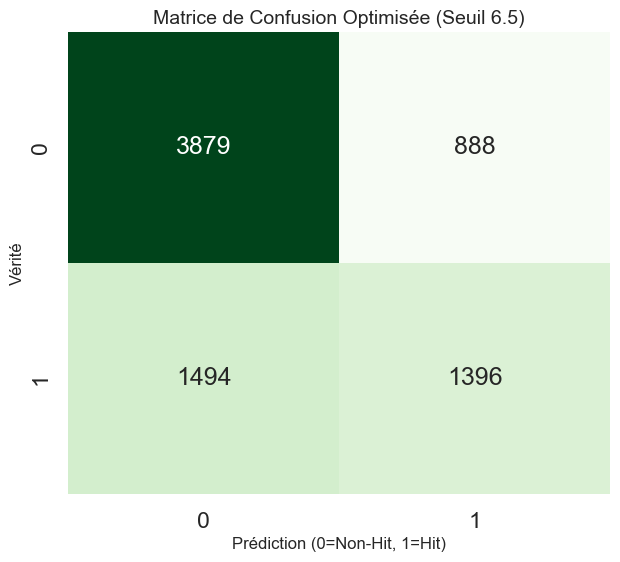


--- Rapport de Classification (Modèle Optimisé) ---
              precision    recall  f1-score   support

           0       0.72      0.81      0.77      4767
           1       0.61      0.48      0.54      2890

    accuracy                           0.69      7657
   macro avg       0.67      0.65      0.65      7657
weighted avg       0.68      0.69      0.68      7657



In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Récupération du Champion ---
# On prend le modèle qui a eu le meilleur score pendant la recherche
best_model = grid_search.best_estimator_

print("🤖 Le meilleur modèle utilise ces paramètres :")
print(grid_search.best_params_)

# --- 2. Prédictions sur le Test Set ---
# Attention : On utilise bien X_test_final (qui ne contient que les nombres)
y_pred_optim = best_model.predict(X_test)

# --- 3. Matrice de Confusion ---
cm_optim = confusion_matrix(y_test_bin, y_pred_optim)

plt.figure(figsize=(7, 6))
# J'utilise une couleur différente (Vert) pour bien différencier du modèle précédent
sns.heatmap(cm_optim, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title(f"Matrice de Confusion Optimisée (Seuil {seuil_hit_binaire})", fontsize=14)
plt.xlabel("Prédiction (0=Non-Hit, 1=Hit)", fontsize=12)
plt.ylabel("Vérité", fontsize=12)
plt.show()

# --- 4. Rapport Détaillé ---
print("\n--- Rapport de Classification (Modèle Optimisé) ---")
print(classification_report(y_test_bin, y_pred_optim))

## Importance Feature 

c:\Users\maeva\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


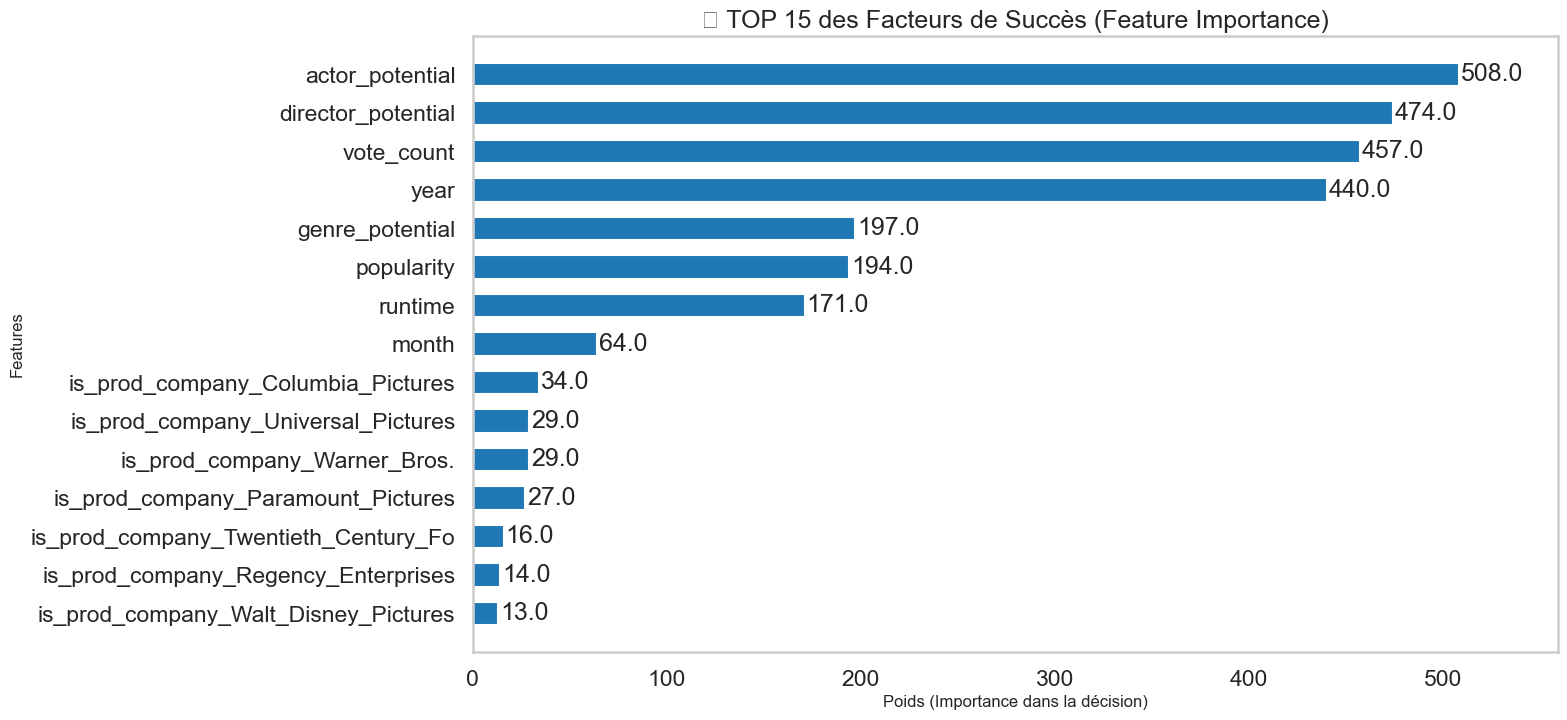

In [54]:
from xgboost import plot_importance

plot_importance(
    best_model, 
    max_num_features=15, 
    height=0.6, 
    importance_type='weight', # 'weight' = nombre de fois que la feature est utilisée pour couper l'arbre
    color='#1f77b4',          # Bleu pro
    title="🏆 TOP 15 des Facteurs de Succès (Feature Importance)",
    grid=False
)

plt.xlabel("Poids (Importance dans la décision)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.show()